
# Simplicity of Naive Bayes Classifiers: Benefit and Bane


The goal of this notebook is to understand the **benefit and bane** of the Naive Bayes (NB) algorithm.

More specifically, we will **<font color=red> investigate the limitation</font>** of the NB classifier.

First, let's briefly discuss the benefit of the NB classifier.


## Benefit of "Simplicity"

The Naive Bayes algorithm is fueled by two "simplicity".
    - Simple inductive bias: conditional independence
    - Simple computation: statistical estimation of the prior and likelihood


In the NB classifier, we make a strong assumption: **given the class, the features are conditionaly independent**. The model is called "naive" because we do not expect the features to be independent, even conditional on the class label.

However, for solving text classification problems we see that although the naive Bayes assumption is an extremely strong assumption, the performance of the NB classifier is surprisingly good.

The reason NB classifier works well in text classification problems is that the conditional independence is a reasonalble assumption in the context of text classification. 

As an example, consider classifying emails into spam and ham. Words like "lottery", "prize" and "win" are all likely indicators that the email might be spam. On the other hand words like "Bayes", "Learning", "Classifier" are good indicators of a ham email. Thus, we could model the **probability of occurrence for each of these words independently, given the respective class** and then use it to score the likelihood of a text.



## Bane of "Simplicity"

However, the conditional independence assumption might not hold in some domains. For example, in image classification problems if we use pixel values to model the feature vectors, then the NB assumption fails. The reason is that the feature values (pixels) are not conditionally independent. The **pixels are not independently generated, depending only on the label**. If we look at a black pixel at one of the corners, the other pixels around is is likely to be black.

Thus, the NB assumption does not hold for the feature values (pixels) in an image classification problem.

Because of its simplicity, Naive Bayes was a very popular choice for building spam filters during 80s and 90s. However, for classifying images it is not as effective. The main reason, as we identified, is the inadequacy of its simplicity! The inductive bias (conditional independence assumption) simply doesn't hold in many domains (e.g., image classification).

It is due to this incorrect assumption about the "world", NB classifiers lost its popularity. Advanced models such as Artificial Neural Network was invented for image classification. 


In this notebook, we will use NB classifier to **solve an image classification problem**. We will compare the performance of the NB classifier with the K-Nearest Neighbor (KNN) memory-based model that we learned previously.


## Datset

We use the MNIST (Modified National Institute of Standards and Technology) dataset. It is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

Each image is labeled with the digit it represents. Each image is represented by 28 x 28 gray scale. There are 784 pixel values. Each value represents a pixel’s intensity, from 0 (white) to 255 (black). 


## NB Models for Investigation

We model a feature vector (an image) as a 784 dimensional vector. Each dimension represents an individual pixel value. Since the pixels represent light intensity in the range of 0 ~ 255, we have two choices to model the feature values.

- Multi-valued categorical (value of a pixel can be 0 ~ 255)
- Real-valued


Thus, we implement two NB classifiers:
- Gaussian NB model 
- Multinomial NB model

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

## Load Data, Create Data Matrix (X) & Target Vector (y)

In [2]:
mnist = fetch_openml('mnist_784', cache=False)

#print("DESCR: \n", mnist.DESCR)
print(mnist.keys())
print(mnist.target)


X = mnist.data.astype('float32')
y = mnist.target.astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)

dict_keys(['categories', 'DESCR', 'details', 'url', 'target', 'feature_names', 'data'])
['5' '0' '4' ... '4' '5' '6']

No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


## Display a Random Image

To display a digit, we need to reshape an instance’s feature vector to a 28 x 28 array. 

For displaying we use Matplotlib’s imshow() function:.

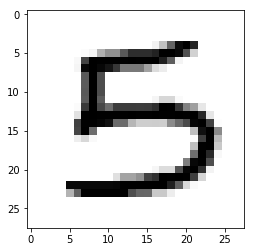

In [3]:
random_digit = X[33528]

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = plt.cm.binary, interpolation="nearest")
#plt.axis("off")
plt.show()

## Data Saling

To avoid big weights that deal with the pixel values from between [0, 255], we scale X down.

A commonly used range is [0, 1].

In [4]:
X /= 255.0

X.min(), X.max()

(0.0, 1.0)

## Create Train and Test Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into **random** train and test subsets.

For the **reproducibility of the results**, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function. 

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Gaussian NB: Model Selection

We need to find the optimal value for the hyperparameter "var_smoothing".

It represents the portion of the largest variance of all features that is added to variances for calculation stability. Its default vale is 1e-9.

In [6]:
%%time
param_grid = {'var_smoothing': [0.001, 0.01, 0.1, 1.0]}

gnb = GaussianNB()

gnb = GridSearchCV(gnb, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)
gnb.fit(X_train, y_train)

params_optimal = gnb.best_params_

print("Best Score (accuracy): %f" % gnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.7s finished


Best Score (accuracy): 0.804143
Optimal Hyperparameter Values:  {'var_smoothing': 0.1}
CPU times: user 675 ms, sys: 445 ms, total: 1.12 s
Wall time: 16.3 s


## Train The Optimal Gaussian NB Model

In [7]:
%%time

gaussianNB_clf = GaussianNB(**params_optimal)

gaussianNB_clf.fit(X_train, y_train) 

CPU times: user 333 ms, sys: 98 ms, total: 431 ms
Wall time: 429 ms


## Evaluate the Optimal Gaussian Model on Test Data

In [8]:
y_test_predicted = gaussianNB_clf.predict(X_test)


accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Accuracy:  0.7939285714285714

Test Confusion Matrix:
[[1243    0    3    6    1   25   37    0   61   11]
 [   0 1537    2    6    2    1    9    0   21    2]
 [  18   62 1078   37   14    2  106   14  103    9]
 [   7   87   63 1066    1   32   16   21   76   66]
 [   2   19   10    0  887   10   21    3   29  369]
 [  31   46   12  150   30  760   34   12   92   64]
 [  16   40   14    0   13   20 1260    1   23    0]
 [   6   72    6    4   44    0    1 1149   37  139]
 [   5  167   15   60   15   28    8    2  973   95]
 [  11   45    5   11   60    2    0   30   35 1162]]

Test Precision = 0.793929

Test Recall = 0.793929

Test F1 Score = 0.793929

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1387
           1       0.74      0.97      0.84      1580
           2       0.89      0.75      0.81      1443
           3       0.80      0.74      0.77      1435
           4       0.83      0.66      0.7

# Multinomial NB: Model Selection

We need to find the optimal value for the hyperparameter "alpha".

It is the additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing). Its default vale is 1.0

In [9]:
%%time

param_grid = {'alpha': [0.1, 1.0, 2.0]}

mnb = MultinomialNB()

mnb = GridSearchCV(mnb, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)
mnb.fit(X_train, y_train)

params_optimal = mnb.best_params_

print("Best Score (accuracy): %f" % mnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished


Best Score (accuracy): 0.827286
Optimal Hyperparameter Values:  {'alpha': 0.1}
CPU times: user 667 ms, sys: 383 ms, total: 1.05 s
Wall time: 6.96 s


## Train The Optimal Multinomial NB Model

In [10]:
%%time

multinomialNB_clf = MultinomialNB(**params_optimal)

multinomialNB_clf.fit(X_train, y_train) 

CPU times: user 404 ms, sys: 139 ms, total: 543 ms
Wall time: 359 ms


## Evaluate the Optimal Multinomial Model on Test Data

In [11]:
y_test_predicted_mnb = multinomialNB_clf.predict(X_test)


accuracy_score_test = np.mean(y_test_predicted_mnb == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_mnb))

precision_test = precision_score(y_test, y_test_predicted_mnb, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted_mnb, average='micro')
print("\nTest Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted_mnb, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_mnb))


Accuracy:  0.8187857142857143

Test Confusion Matrix:
[[1260    0    7    7    2   19   23    0   69    0]
 [   0 1487    8   14    3    3    9    0   54    2]
 [  21   20 1181   33   12    0   71   12   88    5]
 [   3   27   80 1145    0   37    9   17   69   48]
 [   2    3    8    2 1008    6   25    3   56  237]
 [  33   11   17  155   29  794   30    3  119   40]
 [  19   24   24    0   13   25 1261    0   21    0]
 [   9   20   13    8   46    0    2 1169   69  122]
 [   4   83   17   85   23   39    8    3 1047   59]
 [   9   16    8   17   87    3    0   41   69 1111]]

Test Precision = 0.818786

Test Recall = 0.818786

Test F1 Score = 0.818786

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1387
           1       0.88      0.94      0.91      1580
           2       0.87      0.82      0.84      1443
           3       0.78      0.80      0.79      1435
           4       0.82      0.75      0.7

## Multinomial vs Gaussian Naive Bayes for Image Classification

The multinomial Naive Bayes classifier performs better than the Gaussian variant. 

In fact, each sample can be thought as a feature vector derived from a dictionary of 764 symbols. The value can be the count of each occurrence, so a multinomial distribution can better fit the data, while a Gaussian is slightly more limited by its mean and variance.


# KNN Classifier

The model selection for the KNN classifier on the MNIST dataset takes awefully long time. 

Below we provide the commented out code that we used to find the optimal KNN model.

In [ ]:
# %%time

# param_grid_knn = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

# knn = KNeighborsClassifier()

# knn_cv = GridSearchCV(knn, param_grid_knn, cv=5, verbose=3, n_jobs=-1)

# knn_cv.fit(X_train, y_train_5)

# params_optimal_knn = knn_cv.best_params_

# print("Best Score: %f" % knn_cv.best_score_)
# print("Optimal Hyperparameter Values: ", params_optimal_knn)

## Train The Optimal KNN Classifier

The optimal hyperparameters for the KNN model are:
- weights = "distance"
- n_neighbots = 4

In [12]:
%%time

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn_clf.fit(X_train, y_train)

y_test_predicted_knn = knn_clf.predict(X_test)

CPU times: user 14min 43s, sys: 2.23 s, total: 14min 46s
Wall time: 14min 47s


## Evaluate the Optimal KNN Model on Test Data

In [13]:

accuracy_score_test = np.mean(y_test_predicted_knn == y_test)
print("\nAccuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_knn))

precision_test = precision_score(y_test, y_test_predicted_knn, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted_knn, average='micro')
print("\nTest Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted_knn, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_knn))


Accuracy:  0.9734285714285714

Test Confusion Matrix:
[[1374    1    1    1    0    0    9    0    1    0]
 [   0 1576    2    1    0    0    0    1    0    0]
 [   7    8 1397    3    2    0    1   18    6    1]
 [   0    2   17 1380    1   11    0    7   15    2]
 [   1    6    0    0 1312    0    0    4    1   26]
 [   1    2    1   10    1 1187   18    2    3    6]
 [   4    2    0    0    5    6 1369    0    1    0]
 [   0   16    5    0    1    0    0 1422    1   13]
 [   2   19    3   11    4   20    4    0 1287   18]
 [   1    0    1    8   11    2    1   12    1 1324]]

Test Precision = 0.973429

Test Recall = 0.973429

Test F1 Score = 0.973429

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1387
           1       0.97      1.00      0.98      1580
           2       0.98      0.97      0.97      1443
           3       0.98      0.96      0.97      1435
           4       0.98      0.97      0.9

## Observation:


While the KNN clssifier accuracy is 97%, the NB classifier (multinomial) accuracy is only about 82%. 

The poor perfomance of the NB classifier is due to the inadequacy of the naive Bayes assumption in the image classfication domain, especially when pixels represent the feature values. It is indeed incorrect to assume that each and every pixel are independently generated, depending only on the label. 

Thus, while we can independently compute the likelihood of the values of a feature vector in text classfication, and take the product of the individual likelihood values to estimate the feature vector likelihood, this is indeed not the case in image classification.

The words (mostly) in a document are representative micro-unit of the class of the document. Each word independetly bear the "smell" of the class.

However, in image classification, when we use pixel values as the values of a feature vector, they no more are representative of the class. The pixel micro-units don't have enough "information" to individually relate to the class of the feature.

However, we can use clusters of pixels (meaningful patches from an image) to define "visual words" and use them as components of the feature vector. By doing this we can extend the "bag of words" model to solve object classification in computer vision using NB algorithm.

More detail on object recognition using visual "bag of words" model:
http://vision.stanford.edu/teaching/cs231a_autumn1112/lecture/lecture15_bow_part-based_cs231a_marked.pdf


# <font color=red> Key Lesson:</font>

The success of the NB algorithm depends the feature values. If the feature values (textual or visual words) independently relate to the class of the sample, then we can apply the NB assumption. And as long as we can apply the NB assumption meaningfully, the NB algorithm will perform well.